In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import wiener

def load_audio_files(dataset_path, digits=('01', '02')):
    audio_files = []
    labels = []

    for digit in digits:
        digit_path = os.path.join(dataset_path, digit)
        if os.path.exists(digit_path):
            for file in os.listdir(digit_path):
                if file.endswith('.wav'):
                    audio_files.append(os.path.join(digit_path, file))
                    labels.append(int(file[0]))

    return audio_files, labels

def preprocess_audio(file_path, sr=16000):

    y, sr = librosa.load(file_path, sr=sr)


    y = librosa.util.normalize(y)

    # Noise Reduction using Wiener filter
    y = wiener(y)

    y, _ = librosa.effects.trim(y, top_db=20) #remove silence

    return y, sr

def extract_features(y, sr):

    features = {}

# lower-order coefficients capture spectral envelope information and higher-order coefficients capture finer details
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
    for i in range(10):
        features[f'mfcc_{i+1}'] = np.mean(mfccs[i, :])


#indicating where most of the energy is concentrated in frequency
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid'] = np.mean(spectral_centroid)


#Defines the frequency below which a specified percentage
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff'] = np.mean(spectral_rolloff)

#Higher ZCR values indicate unvoiced sounds (e.g., consonants), while lower values indicate voiced sounds
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate'] = np.mean(zcr)


#Represents the energy distribution,
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)


#Helps in distinguishing between loud and quiet speech segments
    rmse = librosa.feature.rms(y=y)
    features['rmse'] = np.mean(rmse)

    return features


def load_the_data(dataset_path):

    audio_files, labels = load_audio_files(dataset_path)

    data = []
    for file, label in zip(audio_files, labels):
        y, sr = preprocess_audio(file)
        features = extract_features(y, sr)
        features['label'] = label
        data.append(features)


    df = pd.DataFrame(data)
    #print(df.head())

    X = df.drop('label', axis=1)
    target = df['label']

    print("ddddddd", X.shape)

    print("ddddddd", len(set(target)))

    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
    y_train, y_test = np.array(y_train), np.array(y_test)
    # do scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return df, X, target, X_train_scaled, X_test_scaled, y_train, y_test

def visualize(df):
    # Visualization
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df['label'])
    plt.title('Class Distribution')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.show()

    # MFCC Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation')
    plt.show()

    # Feature Distributions
    features_to_plot = ['spectral_centroid', 'spectral_rolloff', 'zero_crossing_rate', 'chroma_mean', 'rmse']
    df[features_to_plot].hist(figsize=(12, 6), bins=30)
    plt.suptitle('Feature Distributions')
    plt.show()

# importing libraries


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from data_uti import load_the_data, visualize

ddddddd (1000, 15)
ddddddd 10


ddddddd (1000, 15)
ddddddd 10


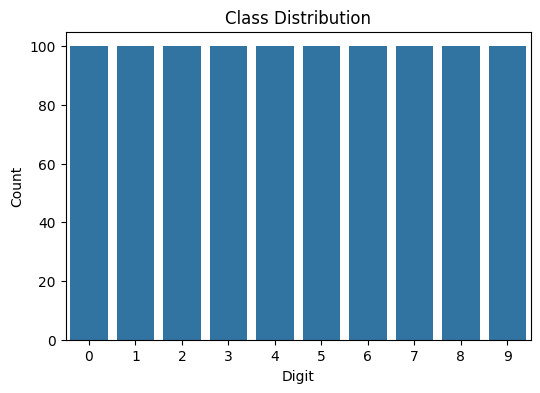

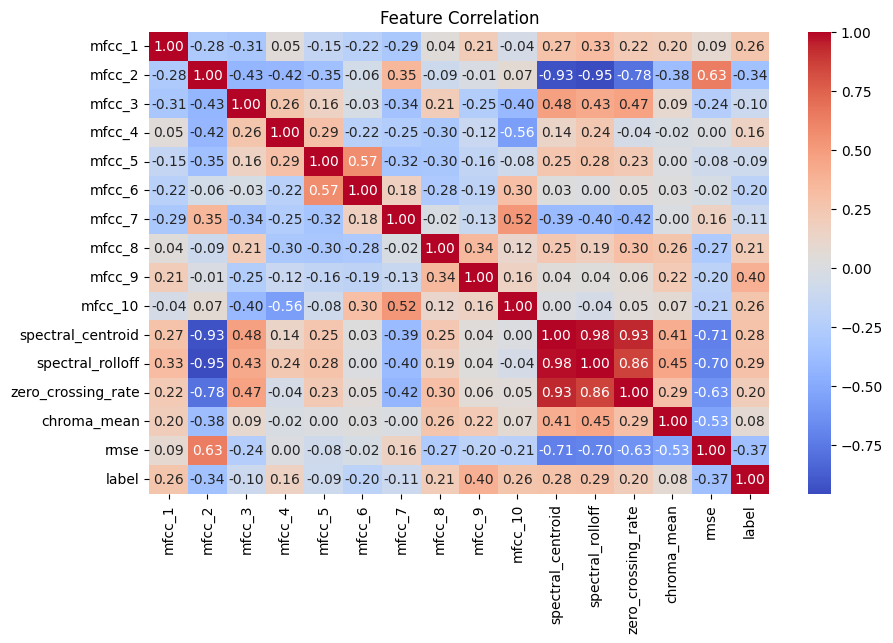

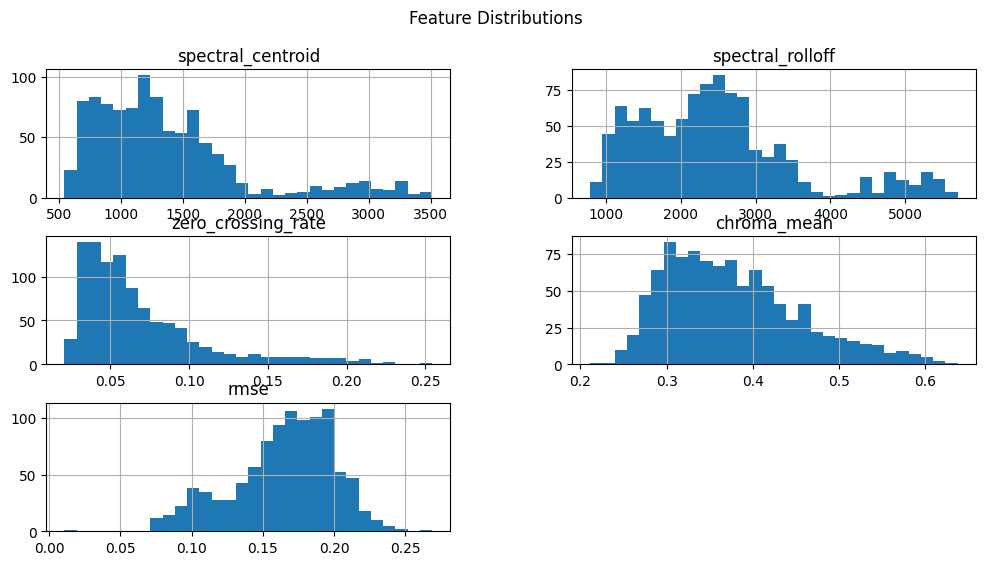

In [ ]:
df, X, y, X_train_scaled, X_test_scaled, y_train, y_test = load_the_data(r"D:\FCAI\Level 3 sem 2\SuperLearning\assigments\ass3\data")
visualize(df)

# naive  bayes (from scratch)

In [ ]:
class NaiveBayes:
  def fit(self, X, y):
      self.classes = np.unique(y)
      self.means = {}
      self.variances = {}
      self.priors = {}

      for c in self.classes:
          X_c = X[y == c]  # Correct indexing
          self.means[c] = np.mean(X_c, axis=0)#mean per class
          self.variances[c] = np.var(X_c, axis=0)#variance per class
          self.priors[c] = len(X_c) / len(X)  # Prior probability

  def likelihood(self, X, c):
    mean = self.means[c]
    variance = self.variances[c]
    epsilon = 1e-6  # Small value to prevent division by zero
    # Calculate likelihood per row Xj for each col Xji
    likelihood = (1 / np.sqrt(2 * np.pi * (variance + epsilon))) *np.exp(-((X - mean) ** 2) / (2 * (variance + epsilon)))
    return np.prod(likelihood, axis=1)# return the prod of all col Xji per row Xj


  def predict(self, X):
    probas = []
    for c in self.classes:
      likelihoods = self.likelihood(X, c)#returns matrix of likelihoods for each class per sample
      posteriors = self.priors[c] * likelihoods
      probas.append(posteriors)
    return self.classes[np.argmax(np.array(probas), axis = 0)] # return max col per row for all rows



#naive bayes Model

In [ ]:
# digits = datasets.load_digits()
# X = digits.data  # Features (64-dimensional vectors representing 8x8 images)
# y = digits.target  # Labels (digits 0-9)

# Print dataset details
print("Dataset shape:", X.shape)
print("Number of classes:", len(set(y)))

# Initialize the Naïve Bayes classifier
nb_model = NaiveBayes()

# Train the model
nb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = nb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[str(i) for i in range(len(set(y)))]))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Dataset shape: (1000, 15)
Number of classes: 10
Accuracy: 0.9750
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       1.00      1.00      1.00        24
           2       1.00      0.94      0.97        18
           3       0.95      1.00      0.98        20
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        21
           6       1.00      0.96      0.98        25
           7       0.94      0.89      0.92        19
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        17

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.98       200

Confusion Matrix:
[[17  0  0  0  0  0  0  1  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 1  0 17  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [

# bulit-in logistic regression

In [ ]:
# Load the Iris dataset
# digits = datasets.load_digits()
# X = digits.data  # Features (64-dimensional vectors representing 8x8 images)
# y = digits.target  # Labels (digits 0-9)

# Print dataset details
print("Dataset shape:", X.shape)
print("Number of classes:", len(set(y)))


# Initialize the Naïve Bayes classifier

model = LogisticRegression(max_iter=5000)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[str(i) for i in range(len(set(y)))]))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Dataset shape: (1000, 15)
Number of classes: 10
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        17

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[18  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [

# Bagging

In [ ]:
import numpy as np
from collections import Counter

class Bagging:
  def __init__(self, base_model, n_estimators=10, bootstrap_ratio=1.0, random_state=42):
    self.base_model = base_model
    self.n_estimators = n_estimators
    self.bootstrap_ratio = bootstrap_ratio
    self.models = []
    self.random_state = random_state
    self.rng = np.random.default_rng(random_state)

  def bootstrap_sample(self, X, y):
    n_samples = int(len(y) * self.bootstrap_ratio)
    indices = self.rng.choice(len(y), size=n_samples, replace=True)
    return X[indices], y[indices]

  def fit(self, X, y):
    for _ in range(self.n_estimators):
      X_boot, y_boot = self.bootstrap_sample(X, y)
      model = self.base_model.__class__(**self.base_model.__dict__)
      model.fit(X_boot, y_boot)
      self.models.append(model)

  def predict(self, X):
    predictions = np.array([model.predict(X) for model in self.models])
    return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)


# Naive Byes bagging


In [ ]:
# Load the digits dataset
# digits = datasets.load_digits()
# X = digits.data  # Features (64-dimensional vectors representing 8x8 images)
# y = digits.target  # Labels (digits 0-9)

# Print dataset details
print("Dataset shape:", X.shape)
print("Number of classes:", len(set(y)))

# Initialize the Naïve Bayes classifier
nb = NaiveBayes()
model = Bagging(nb, n_estimators= 10, bootstrap_ratio=0.5)

print(type(X_train_scaled))
print(type(y_train))
# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[str(i) for i in range(len(set(y)))]))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Dataset shape: (1000, 15)
Number of classes: 10
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Accuracy: 0.9750
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       1.00      1.00      1.00        24
           2       1.00      0.94      0.97        18
           3       0.95      1.00      0.98        20
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        21
           6       1.00      0.96      0.98        25
           7       0.94      0.89      0.92        19
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        17

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.98       200

Confusion Matrix:
[[17  0  0  0  0  0  0  1  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 1  0 17  0  0  0 

# Logistic Regression Bagging

In [ ]:
# Load the digits dataset
# digits = datasets.load_digits()
# X = digits.data  # Features (64-dimensional vectors representing 8x8 images)
# y = digits.target  # Labels (digits 0-9)

# Print dataset details
print("Dataset shape:", X.shape)
print("Number of classes:", len(set(y)))

# Initialize the Naïve Bayes classifier
lr = LogisticRegression(max_iter=5000)
model = Bagging(lr, n_estimators= 70, bootstrap_ratio=0.6)
print(type(X_train_scaled))
print(type(y_train))
# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[str(i) for i in range(len(set(y)))]))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Dataset shape: (1000, 15)
Number of classes: 10
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        17

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[18  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0 

# END